# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
from itertools import product
import random

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_data_utils import split_cell_data, channel_combo_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    summarize_cell_data,
    plot_feature_distributions,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

random.seed(42)

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL_1`: First well identifier used for testing configuration
- `TEST_WELL_2`: Second well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL_1 = "A3"
TEST_WELL_2 = "A3"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_1}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=25000)

merge_final_fp_2 = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_2}, "merge_final", "parquet")
)
cell_data_2 = load_parquet_subset(merge_final_fp_2, n_rows=25000)

cell_data = pd.concat([cell_data, cell_data_2], ignore_index=True)
cell_data

Reading first 25,000 rows from brieflow_output/merge/parquets/P-1_W-A3__merge_final.parquet
Reading first 25,000 rows from brieflow_output/merge/parquets/P-1_W-A3__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,vacuole_area_ratio,mean_vacuole_diameter,mean_distance_to_nucleus,vacuole_mapping_vacuole_id,vacuole_mapping_vacuole_area,vacuole_mapping_vacuole_diameter,vacuole_mapping_distance_to_nucleus,vacuole_mapping_nearest_nucleus_id,vacuole_mapping_cell_id,vacuole_mapping_overlap_ratio
0,1,A3,4045,97,1482.034905,1481.312281,270,975,345.902655,926.601770,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,A3,452,64,1480.569195,1482.436455,38,1236,632.761290,927.625806,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,1,A3,742,66,1482.045931,1477.500604,49,1362,916.492424,929.530303,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1,A3,6245,80,1480.682755,1483.404907,417,89,59.772727,69.558442,...,0.136642,75.702386,47.956391,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1,A3,822,66,1479.485975,1476.248494,70,107,60.367188,927.070312,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A3,325,72,1737.270149,1540.009173,35,119,99.310811,928.155405,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
49996,1,A3,6220,54,1269.221739,1320.741652,408,1536,886.116883,337.896104,...,0.328364,113.709048,81.364224,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
49997,1,A3,675,54,1232.134623,1571.408608,51,1071,600.042553,654.595745,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
49998,1,A3,4861,50,1294.456981,1291.938810,318,945,607.787097,47.677419,...,0.000000,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [5]:
for col in cell_data.columns:
    print(col)

plate
well
tile
cell_0
i_0
j_0
site
cell_1
i_1
j_1
distance
fov_distance_0
fov_distance_1
sgRNA_0
sgRNA_1
gene_symbol_0
gene_symbol_1
mapped_single_gene
channels_min
nucleus_i
nucleus_j
nucleus_bounds_0
nucleus_bounds_1
nucleus_bounds_2
nucleus_bounds_3
cell_i
cell_j
cell_bounds_0
cell_bounds_1
cell_bounds_2
cell_bounds_3
cytoplasm_i
cytoplasm_j
cytoplasm_bounds_0
cytoplasm_bounds_1
cytoplasm_bounds_2
cytoplasm_bounds_3
nucleus_DAPI_int
nucleus_OMP25_int
nucleus_MITOTRACKER_int
nucleus_CONA_int
nucleus_GRA7_int
nucleus_ACTUBULIN_int
nucleus_WGA_int
nucleus_GM130_int
nucleus_DAPI_mean
nucleus_OMP25_mean
nucleus_MITOTRACKER_mean
nucleus_CONA_mean
nucleus_GRA7_mean
nucleus_ACTUBULIN_mean
nucleus_WGA_mean
nucleus_GM130_mean
nucleus_DAPI_std
nucleus_OMP25_std
nucleus_MITOTRACKER_std
nucleus_CONA_std
nucleus_GRA7_std
nucleus_ACTUBULIN_std
nucleus_WGA_std
nucleus_GM130_std
nucleus_DAPI_max
nucleus_OMP25_max
nucleus_MITOTRACKER_max
nucleus_CONA_max
nucleus_GRA7_max
nucleus_ACTUBULIN_max
nucleu

## <font color='red'>SET PARAMETERS</font>

### Cell Data Metadata

- `METADATA_COLS_FP`: Path to TSV to store metadata cols.
- `METADATA_COLS`: Columns in cell data with metadata (use output above).

In [6]:
METADATA_COLS_FP = "config/cell_data_metadata_cols.tsv"
METADATA_COLS = [
    "plate",
    "well",
    "tile",
    "cell_0",
    "i_0",
    "j_0",
    "site",
    "cell_1",
    "i_1",
    "j_1",
    "distance",
    "fov_distance_0",
    "fov_distance_1",
    "sgRNA_0",
    "gene_symbol_0",
    "sgRNA_1",
    "gene_symbol_1",
    "mapped_single_gene",
    "channels_min",
    "nucleus_i",
    "nucleus_j",
    "nucleus_bounds_0",
    "nucleus_bounds_1",
    "nucleus_bounds_2",
    "nucleus_bounds_3",
    "cell_i",
    "cell_j",
    "cell_bounds_0",
    "cell_bounds_1",
    "cell_bounds_2",
    "cell_bounds_3",
    "cytoplasm_i",
    "cytoplasm_j",
    "cytoplasm_bounds_0",
    "cytoplasm_bounds_1",
    "cytoplasm_bounds_2",
    "cytoplasm_bounds_3",
    "has_vacuole",
    "vacuole_ids",
]

In [7]:
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")

metadata, features = split_cell_data(cell_data, METADATA_COLS)
print(metadata.shape, features.shape)

(50000, 39) (50000, 3580)


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes

### Evaluate splitting

- `COLLAPSE_COLS`: Cell data columns to collapse on when creating a summary of cell counts. This will show the number of cells in each cell class for these particular columns. Ex: `["sgRNA_0", "gene_symbol_0"]`.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`.

**Notes**: 
- We generate cell classes for each of the classes listed in the classifier and an "all" class. So for a classifier that splits by mitotic or interphase the final classes will be `["mitotic", "interphase", "all"]`.
- You must import necessary packages for the classifier in this notebook and add them to `scripts/aggregate/split_datasets.py` as well. Ex `import numpy as np` if the classifier requires `numpy`.

In [8]:
CLASSIFIER_PATH = "config/vacuole_classifier.dill"
MONTAGE_CHANNEL = "MITOTRACKER"
COLLAPSE_COLS = ["gene_symbol_0", "sgRNA_0", "gene_symbol_1", "sgRNA_1"]

Cell class counts:
class
naive       31822
infected    18178
Name: count, dtype: int64

Cell class confidences:


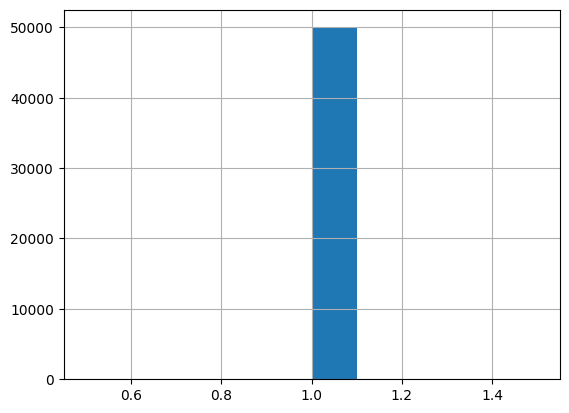

In [9]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
classified_metadata, classified_features = classifier.classify_cells(metadata, features)

# Create config var for cell classes
CELL_CLASSES = list(classified_metadata["class"].unique())

# Show cell class counts and distribution
print("Cell class counts:")
print(classified_metadata["class"].value_counts())

print("\nCell class confidences:")
classified_metadata["confidence"].hist()
plt.show()

Montages of cell classes:


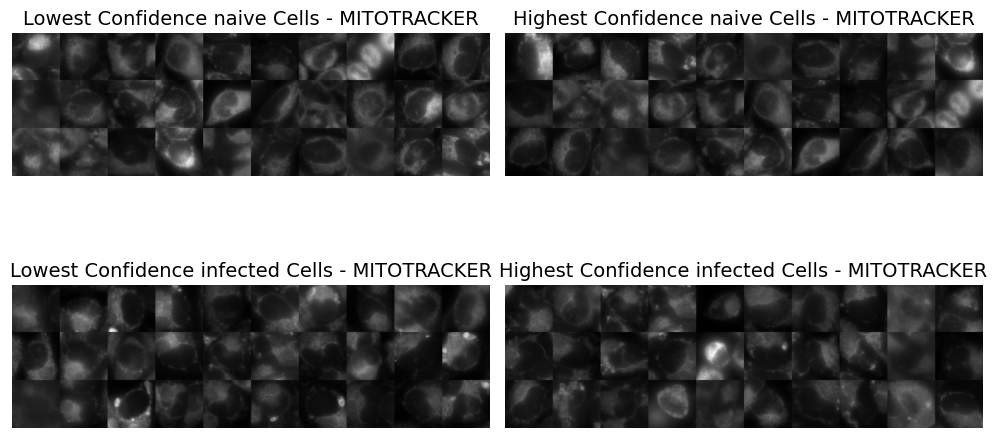

Split cell data summary:


,Stage,Count,Percent
0,Raw Data,50000,100.00
1,naive cells,31822,63.64
2,naive gene_symbol_0,16,0.03
3,naive sgRNA_0,52,0.10
4,naive gene_symbol_1,16,0.03
5,naive sgRNA_1,46,0.09
6,infected cells,18178,36.36
7,infected gene_symbol_0,16,0.03
8,infected sgRNA_0,58,0.12
9,infected gene_symbol_1,16,0.03


In [11]:
cell_classes = list(classified_metadata["class"].unique()) + ["all"]

classified_metadata_copy = classified_metadata.copy(deep=True)
classified_metadata_copy = add_filenames(classified_metadata_copy, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_metadata_copy[classified_metadata_copy["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
            cell_size=100,
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(
            title_templates[ascending].format(
                cell_class=cell_class, channel=MONTAGE_CHANNEL
            )
        )

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

print("Montages of cell classes:")
plt.tight_layout()
plt.show()

print("Split cell data summary:")
summary_df = summarize_cell_data(classified_metadata, CELL_CLASSES, COLLAPSE_COLS)
display(summary_df)

## <font color='red'>SET PARAMETERS</font>

### Aggregate by channel combos

- `CHANNEL_COMBOS`: Combinations of channels to aggregate by. This is a list of lists with channel names, ex `[["DAPI", "CENPA"], ["DAPI", "WGA"]]`.
- `AGGREGATE_COMBO_FP`: Location of aggregate combinations dataframe.
- `TEST_CELL_CLASS`: Cell class to configure aggregate params with. Can be any of the cell classes or `all`.
- `TEST_CHANNEL_COMBO`: Channel combo to configure aggregate params with; must be one of the channel combos. Ex `["DAPI", "CENPA"]`.

In [22]:
CHANNEL_COMBOS = [["DAPI", "OMP25", "MITOTRACKER", "CONA", "GRA7", "ACTUBULIN", "WGA", "GM130"]]
AGGREGATE_COMBO_FP = "config/aggregate_combo.tsv"

TEST_CELL_CLASS = "infected"
TEST_CHANNEL_COMBO = ["DAPI", "OMP25", "MITOTRACKER", "CONA", "GRA7", "ACTUBULIN", "WGA", "GM130"]

In [23]:
# determine cell classes and channel combos
channel_combos = ["_".join(combo) for combo in CHANNEL_COMBOS]

# Load merge wildcard combos
MERGE_COMBO_FP = Path(config["merge"]["merge_combo_fp"])
merge_wildcard_combos = pd.read_csv(MERGE_COMBO_FP, sep="\t")

# Generate aggregate wildcard combos
aggregate_wildcard_combos = pd.DataFrame(
    product(
        merge_wildcard_combos.itertuples(index=False, name=None),
        cell_classes,
        channel_combos,
    ),
    columns=["plate_well", "cell_class", "channel_combo"],
)
aggregate_wildcard_combos[["plate", "well"]] = pd.DataFrame(aggregate_wildcard_combos["plate_well"].tolist(), index=aggregate_wildcard_combos.index)
aggregate_wildcard_combos = aggregate_wildcard_combos.drop(columns="plate_well")

# Save aggregate wildcard combos
aggregate_wildcard_combos.to_csv(AGGREGATE_COMBO_FP, sep="\t", index=False)

print("Aggregate wildcard combos:")
aggregate_wildcard_combos

Aggregate wildcard combos:


,cell_class,channel_combo,plate,well
0,naive,DAPI_OMP25_MITOTRACKER_CONA_GRA7_ACTUBULIN_WGA...,1,A3
1,infected,DAPI_OMP25_MITOTRACKER_CONA_GRA7_ACTUBULIN_WGA...,1,A3
2,all,DAPI_OMP25_MITOTRACKER_CONA_GRA7_ACTUBULIN_WGA...,1,A3


In [24]:
# subset cell class
if TEST_CELL_CLASS != "all":
    cell_class_mask = classified_metadata["class"] == TEST_CELL_CLASS
    class_metadata = classified_metadata[cell_class_mask]
    class_features = classified_features[cell_class_mask]
else:
    class_metadata = classified_metadata
    class_features = classified_features

# subset features
all_channels = config["phenotype"]["channel_names"]
class_features = channel_combo_subset(class_features, TEST_CHANNEL_COMBO, all_channels)

# copy metadata and features for later eval
dataset_metadata = class_metadata.copy()
dataset_features = class_features.copy()

# preview metadata and features
display(class_metadata)
display(class_features)

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_i,cytoplasm_j,cytoplasm_bounds_0,cytoplasm_bounds_1,cytoplasm_bounds_2,cytoplasm_bounds_3,has_vacuole,vacuole_ids,class,confidence
3,1,A3,6245,80,1480.682755,1483.404907,417,89,59.772727,69.558442,...,1450.244151,1443.964930,1355,1356,1577,1570,True,[32],infected,1.0
7,1,A3,6464,170,1476.206893,1483.455302,414,2534,914.508333,356.475000,...,1460.300531,1548.342358,1380,1364,1526,1645,True,"[108, 187]",infected,1.0
11,1,A3,2475,50,1474.688224,1477.073083,181,67,59.026316,70.912281,...,1497.538366,1496.597152,1394,1385,1584,1595,True,[62],infected,1.0
12,1,A3,2866,66,1482.608769,1485.491932,208,87,62.048611,643.319444,...,1472.520036,1557.467536,1371,1402,1602,1685,True,[19],infected,1.0
13,1,A3,5962,70,1475.094715,1484.378622,409,85,58.988827,356.653631,...,1472.953407,1404.055396,1351,1295,1572,1541,True,"[27, 76]",infected,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49989,1,A3,134,70,1445.313162,1218.134437,14,52,56.811189,609.461538,...,1432.340726,1161.596916,1303,1069,1644,1284,True,"[47, 68]",infected,1.0
49990,1,A3,802,67,1610.337655,1250.237719,65,112,76.838235,899.882353,...,1668.595879,1257.715717,1555,1168,1752,1331,True,[66],infected,1.0
49991,1,A3,4232,122,1639.194498,1690.800365,271,1757,936.099099,667.765766,...,1608.322069,1633.292949,1492,1516,1711,1744,True,[6],infected,1.0
49992,1,A3,71,84,1691.689963,1638.013188,8,1963,943.012195,946.286585,...,1642.826857,1574.908320,1534,1425,1771,1759,True,"[35, 46]",infected,1.0


,nucleus_DAPI_int,nucleus_OMP25_int,nucleus_MITOTRACKER_int,nucleus_CONA_int,nucleus_GRA7_int,nucleus_ACTUBULIN_int,nucleus_WGA_int,nucleus_GM130_int,nucleus_DAPI_mean,nucleus_OMP25_mean,...,vacuole_area_ratio,mean_vacuole_diameter,mean_distance_to_nucleus,vacuole_mapping_vacuole_id,vacuole_mapping_vacuole_area,vacuole_mapping_vacuole_diameter,vacuole_mapping_distance_to_nucleus,vacuole_mapping_nearest_nucleus_id,vacuole_mapping_cell_id,vacuole_mapping_overlap_ratio
3,86249063,8732170,36069412,4225242,34771683,8302565,89015253,39470967,6892.205770,697.792073,...,0.136642,75.702386,47.956391,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,74729223,3186319,14309521,3590111,3318717,4141869,54202341,13631361,8642.213831,368.488377,...,0.120727,41.172653,120.038072,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
11,40656104,5468774,28085411,2579460,14743329,2709761,63100896,28397349,4441.348482,597.419052,...,0.023509,26.986905,3.768809,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
12,44824607,3022376,21578634,3404699,1643997,1563286,45053214,6173166,3786.821576,255.332939,...,0.059741,58.382037,130.975045,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
13,43045414,4900427,20533359,2189069,87948219,10019842,75460883,41430054,3380.618393,384.860363,...,0.219855,68.768993,50.376770,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49989,53928501,2842968,24897138,1824753,34139162,11176940,82101655,56456343,4464.279884,235.345033,...,0.066978,42.482625,102.371109,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
49990,48775024,6728920,34645921,2649892,3244002,1742879,57255369,13429039,5141.790428,709.352730,...,0.043821,35.700319,81.159670,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
49991,46256342,10694563,32016534,2446275,35578606,5351801,86601143,32131142,5279.801621,1220.701176,...,0.447375,114.206243,39.656474,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
49992,54414096,3425882,22850516,1785365,13165014,8029636,69647538,45186127,4054.399523,255.262797,...,0.114629,59.687481,78.230891,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [25]:
# Count how many cells have mapped_single_gene equal to False/0
no_single_gene_count = (class_metadata['mapped_single_gene'] == False).sum()
print(f"Cells with mapped_single_gene = False: {no_single_gene_count}")

# Value counts to see the breakdown and show NAs
print("\nMapped single gene breakdown:")
print(class_metadata['mapped_single_gene'].value_counts(dropna=False))

Cells with mapped_single_gene = False: 1202

Mapped single gene breakdown:
mapped_single_gene
None     11336
True      5640
False     1202
Name: count, dtype: int64


In [26]:
# Create subset with the three gene-related columns
gene_subset = class_metadata[['mapped_single_gene', 'gene_symbol_0', 'gene_symbol_1']].copy()

# Display first few rows
print("Gene mapping subset:")
display(gene_subset)

# Or filter to just the unmapped cells to see what's going on
unmapped_cells = gene_subset[gene_subset['mapped_single_gene'] == False]
print(f"\nUnmapped cells ({len(unmapped_cells)} total):")
display(unmapped_cells)

Gene mapping subset:


,mapped_single_gene,gene_symbol_0,gene_symbol_1
3,True,nontargeting_GCATAG,<NA>
7,None,<NA>,<NA>
11,None,<NA>,<NA>
12,None,<NA>,<NA>
13,True,TGGT1_220950,<NA>
...,...,...,...
49989,True,TGGT1_220950,<NA>
49990,True,TGGT1_227620,<NA>
49991,None,<NA>,<NA>
49992,False,TGGT1_227620,TGGT1_275440



Unmapped cells (1202 total):


,mapped_single_gene,gene_symbol_0,gene_symbol_1
20,False,TGGT1_231960,TGGT1_272460
51,False,TGGT1_227620,TGGT1_231960
105,False,TGGT1_231960,TGGT1_227620
152,False,TGGT1_214080,TGGT1_227620
189,False,TGGT1_227620,TGGT1_254470
...,...,...,...
49846,False,TGGT1_227620,TGGT1_223580
49870,False,TGGT1_214080,TGGT1_220950
49963,False,TGGT1_227620,TGGT1_220950
49983,False,TGGT1_220950,TGGT1_231960


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == True", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbations. This is the column that aggregation takes place on. Ex "gene_symbol_0".

In [27]:
FILTER_QUERIES = ["mapped_single_gene == True"]
PERTURBATION_NAME_COL = "gene_symbol_0"

Query 'mapped_single_gene == True' filtered out 12538 cells
Found 5640 cells with assigned perturbations
Unique populations: 16
                                  column  percent_na
78            cytoplasm_DAPI_mean_frac_0    0.160638
79           cytoplasm_OMP25_mean_frac_0    0.160638
80     cytoplasm_MITOTRACKER_mean_frac_0    0.160638
81            cytoplasm_CONA_mean_frac_0    0.160638
82            cytoplasm_GRA7_mean_frac_0    0.160638
83       cytoplasm_ACTUBULIN_mean_frac_0    0.160638
84             cytoplasm_WGA_mean_frac_0    0.160638
85           cytoplasm_GM130_mean_frac_0    0.160638
94            cytoplasm_DAPI_radial_cv_0    0.160638
95           cytoplasm_OMP25_radial_cv_0    0.160638
96     cytoplasm_MITOTRACKER_radial_cv_0    0.160638
97            cytoplasm_CONA_radial_cv_0    0.160638
98            cytoplasm_GRA7_radial_cv_0    0.160638
99       cytoplasm_ACTUBULIN_radial_cv_0    0.160638
100            cytoplasm_WGA_radial_cv_0    0.160638
101          cytoplasm_G

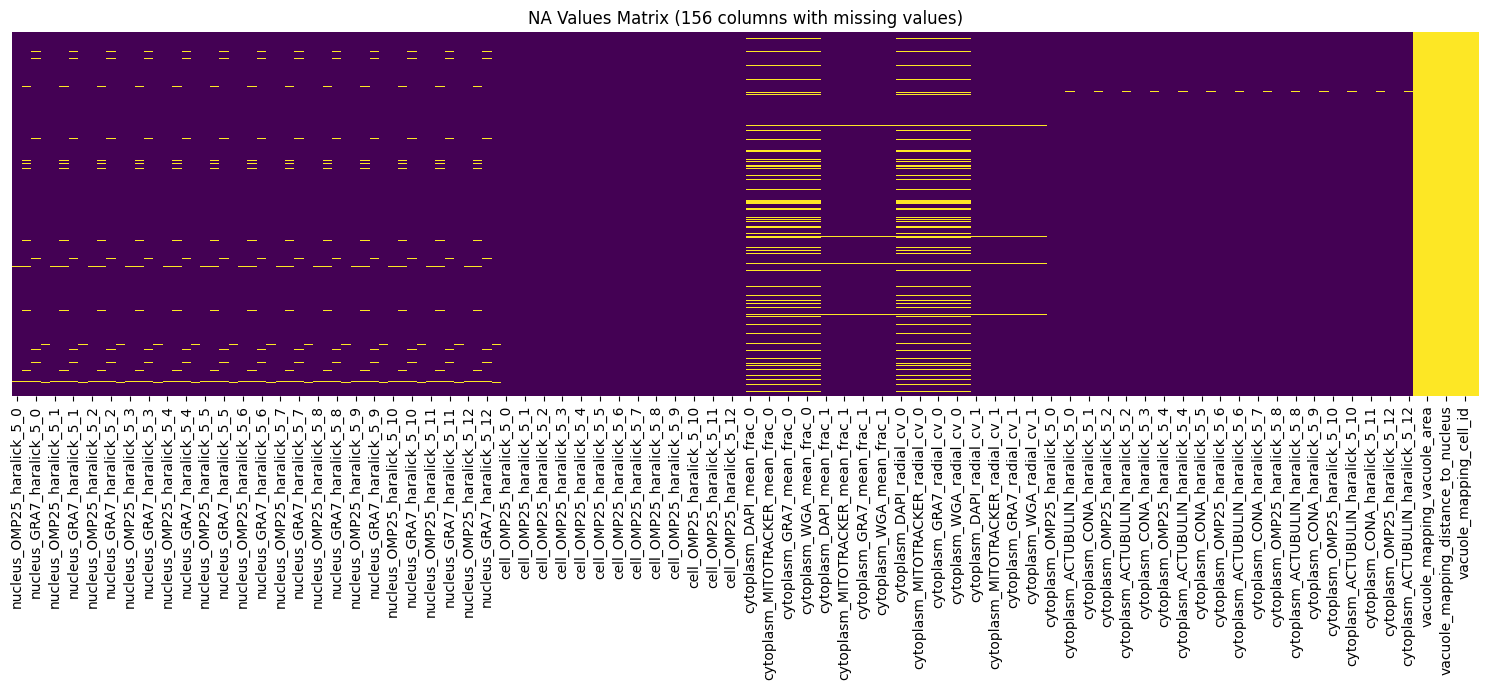

In [28]:
qf_metadata, qf_features = query_filter(class_metadata, class_features, FILTER_QUERIES)

pf_metadata, pf_features = perturbation_filter(
    qf_metadata, qf_features, PERTURBATION_NAME_COL
)
print(f"Unique populations: {metadata[PERTURBATION_NAME_COL].nunique()}")

summary_df, fig = nas_summary(pf_features)
print(summary_df[summary_df["percent_na"] > 0.1])
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [29]:
DROP_COLS_THRESHOLD = 0.1
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [30]:
# Filter by missing values
mvf_metadata, mvf_features = missing_values_filter(
    pf_metadata,
    pf_features,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

mvf_metadata.shape, mvf_features.shape

Dropping 23 columns with ≥10.0% missing values
Dropped 10 rows with ≥1.0% missing values
Imputing 107 columns with remaining missing values using batched KNN
Imputing for batch 1 with 334 NA rows


((5630, 41), (5630, 3557))

## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [31]:
CONTAMINATION = 0.01

In [32]:
# Filter by intensity outliers
if_metadata, if_features = intensity_filter(
    mvf_metadata,
    mvf_features,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

if_metadata.shape, if_features.shape

((5574, 41), (5574, 3557))

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations. Only needed if you want your controls to have different perturbation names, ex `sgRNA_0`. Otherwise, can leave this as `None`.

In [33]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting"
PERTURBATION_ID_COL = "sgRNA_0"

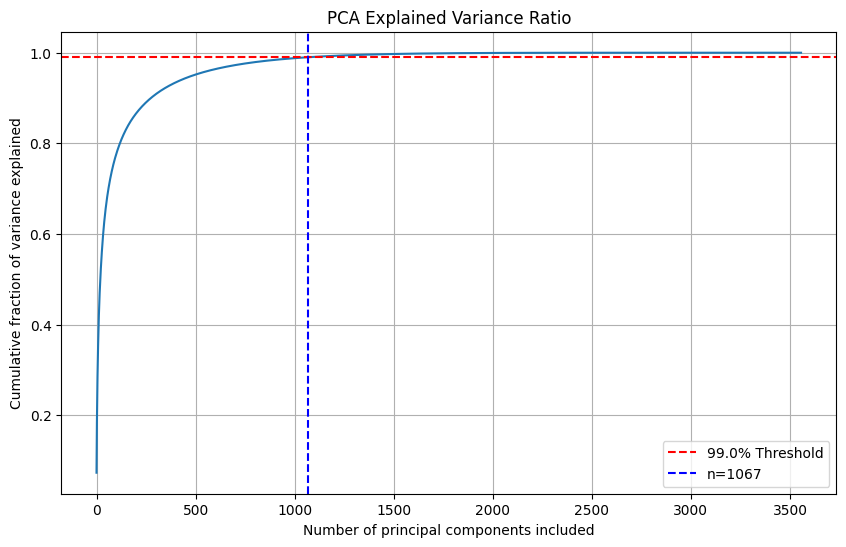

In [34]:
pad_metadata, pad_features = prepare_alignment_data(
    if_metadata, if_features, BATCH_COLS, PERTURBATION_NAME_COL, CONTROL_KEY, PERTURBATION_ID_COL
)

n_components, fig = pca_variance_plot(
    pad_features, variance_threshold=0.99
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `VARIANCE_OR_NCOMP`: Variance or number of components to keep after PCA.
- `NUM_ALIGN_BATCHES`: Number of batches to use when aligning, usually `1`. Increase this if you are running out of memory while aligning. We were able to barely fit 8 plates with 6 wells each in 1 TB of memory with `NUM_ALIGN_BATCHES=1`.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `median`.

While we use a simplified aggregate method in the notebook, the way this works during a normal run is:
1) Take a subset of 1,000,000 cells, or the entire dataset, whichever is smaller and compute a PCA transform with `VARIANCE_OR_NCOMP`.
2) Subset the entire dataset `NUM_BATCHES` number of times and align cells in this batch.
3) Aggregate across all aligned cell data.

In [35]:
VARIANCE_OR_NCOMP = 0.99
NUM_ALIGN_BATCHES = 1
AGG_METHOD = "median"

In [36]:
pca_embeddings = embed_by_pca(
    pad_features, pad_metadata, variance_or_ncomp=VARIANCE_OR_NCOMP, batch_col="batch_values"
)

tvn_normalized = tvn_on_controls(
    pca_embeddings, pad_metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, pad_metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=pad_metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([pad_metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

/lab/ops_analysis/cheeseman/olives-analysis/brieflow/workflow/lib/aggregate/align.py:244: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/lab/ops_analysis/cheeseman/olives-analysis/brieflow/workflow/lib/aggregate/align.py:174: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()


/lab/ops_analysis/cheeseman/olives-analysis/brieflow/workflow/lib/aggregate/eval_aggregate.py:130: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_orig = df_orig.groupby(["Feature", "plate_well"], group_keys=False).apply(
/lab/ops_analysis/cheeseman/olives-analysis/brieflow/workflow/lib/aggregate/eval_aggregate.py:136: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_aligned = df_aligned.groupby(["Feature", "plate_w

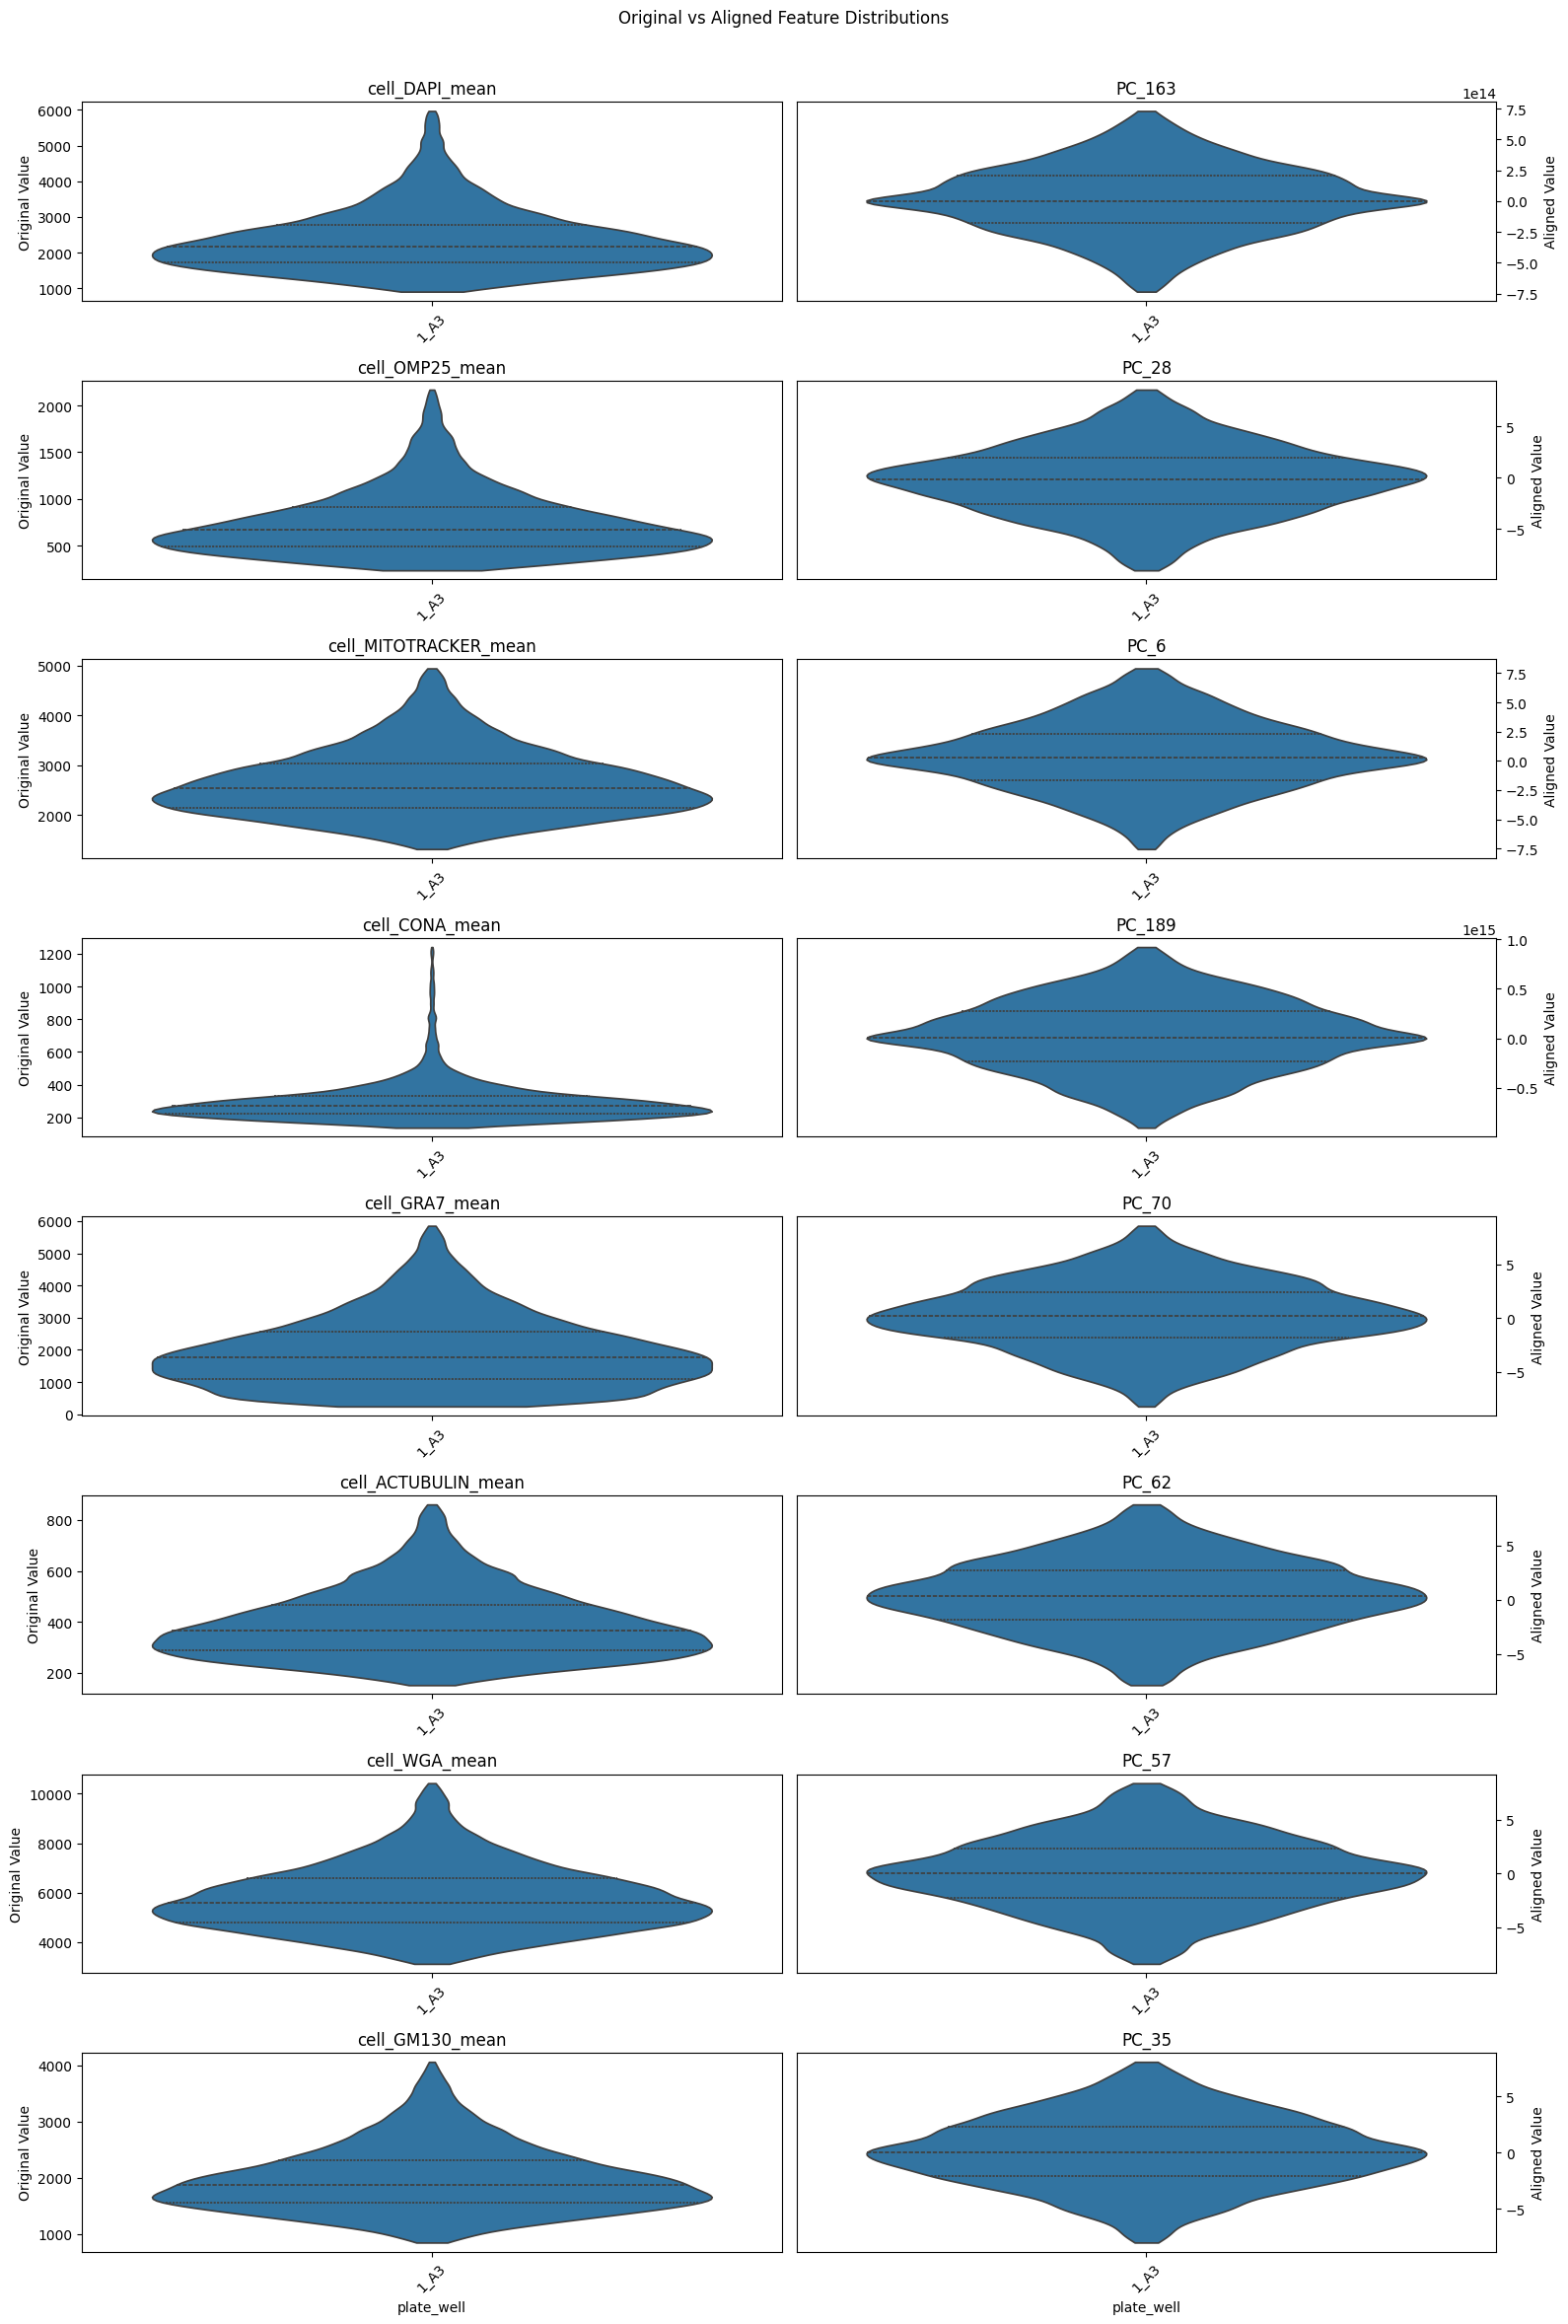

In [37]:
original_feature_cols = [col for col in dataset_features.columns if ("cell_" in col and col.endswith("_mean"))]
pc_cols = [col for col in aggregated_cell_data.columns if col.startswith("PC_")]
aligned_feature_cols = random.sample(pc_cols, k=min(len(original_feature_cols), len(pc_cols)))

original_cell_data = pd.concat([dataset_metadata, dataset_features], axis=1)
original_cell_data

feature_distributions_fig = plot_feature_distributions(
    original_feature_cols,
    original_cell_data,
    aligned_feature_cols,
    aligned_cell_data,
)
plt.show()

## Add aggregate parameters to config file

In [38]:
# Add aggregate section
config["aggregate"] = {
    "metadata_cols_fp": METADATA_COLS_FP,
    "collapse_cols": COLLAPSE_COLS,
    "classifier_path": CLASSIFIER_PATH,
    "aggregate_combo_fp": AGGREGATE_COMBO_FP,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "variance_or_ncomp": VARIANCE_OR_NCOMP,
    "num_align_batches": NUM_ALIGN_BATCHES,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)